In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import imageio

In [2]:
# generates test data
def noisy_fringes(x_y_tuple,
                 amplitude=0.5,
                 offset=0.5,
                 spatial_frequency=5,
                 rotation=0,
                 phase=0,
                 loc=0,
                 scale=0.3,
                 ):
    image = fringes(x_y_tuple,
                    amplitude=amplitude,
                    offset=offset,
                    spatial_frequency=spatial_frequency,
                    rotation=rotation,
                    phase=phase)
    generator = np.random.default_rng()
    noisy_image = image + generator.normal(size=image.shape,
                                           loc=loc,
                                           scale=scale)
    return noisy_image


In [3]:
# naive guess at function to fit fringes
# spatial frequency is in normalised units
# rotation is counterclockwise in radians with respect to the x axis
def fringes(x_y_tuple,
            amplitude=0.5,
            offset=0.5,
            spatial_frequency=5,
            rotation=0,
            phase=0):
    xx, yy = x_y_tuple  # unpacking independent variables
    rotation+=np.pi/2
    # using euclidean rotation matrix to calculate rotated coordinate system
    x_rotated =  xx*np.cos(rotation)+yy*np.sin(rotation)
    y_rotated = -xx*np.sin(rotation)+yy*np.cos(rotation)

    period = 1/(spatial_frequency*2*np.pi)
    frequency = 1/period
    z = amplitude*np.sin(frequency*x_rotated + phase)+offset
    return np.ravel(z)

In [4]:
# Define bounds for fitting
bounds = [(0.1, -1, 2,  0,       0),
          (2,    1, 20, np.pi,   2*np.pi)]

# Switch between using image and generating noisy image
read_png = False
filename = "example.png"

# Test using actual image
if read_png:
    noisy_image = imageio.imread(filename)
    # Only using green channel, should do something better than this
    # but this works just for an example
    # Note: reversing order of y since image coordinate system has
    # origin in upper left instead of lower left
    noisy_image = np.asarray(noisy_image[:, ::-1, 1], dtype=float)
    # Transpose to stay consistent with matrix representation 
    noisy_image = noisy_image.T
    shape = noisy_image.shape
    len_x, len_y = noisy_image.shape 
    x, y = np.meshgrid(np.linspace(0, 1, len_x),
                       np.linspace(0, len_y/len_x, len_y), indexing="ij")
    noisy_image -= noisy_image.min()
    noisy_image /= noisy_image.max()
    noisy_image = noisy_image.ravel()

# Test with noisy data
else:
    len_x, len_y = (100, 200)
    shape = (len_x, len_y)
    x, y = np.meshgrid(np.linspace(0, 1, len_x),
                       np.linspace(0, len_y/len_x, len_y),
                       indexing="ij")
    generator = np.random.default_rng()
     
    noisy_image = noisy_fringes((x, y),
                                rotation = generator.normal(scale=2, loc=0),
                                spatial_frequency = generator.normal(scale=2, loc=5)
                                )

In [5]:
# Wrap the fringe function to use scipy's differential
# evolution function
def wrapped_fringes(params): 
    return np.sum((noisy_image - fringes((x, y), *params))**2)

In [6]:
# We're using scipy's differential evolution function to find a good guess
# of appropriate parameters, curve fit by itself typically gets stuck in
# local minima otherwise
res = opt.differential_evolution(wrapped_fringes,
                                 bounds=((0.1, 2),       # Amplitude
                                         (-1, 1),        # Offset
                                         (2, 20),        # Spatial frequency
                                         (0, np.pi),     # Rotation
                                         (0, 2*np.pi)))  # Phase

guess = res.x
print(guess)

[0.5016084  0.50339899 5.69776222 2.5985476  6.28318531]


Fitted parameters
----------------------------------------
Amplitude            = 0.502 +- 0.003
Offset               = 0.503 +- 0.002
Spatial frequency    = 5.698 +- 0.002
Rotation             = 2.599 +- 0.001
Phase                = 6.283 +- 0.016
----------------------------------------


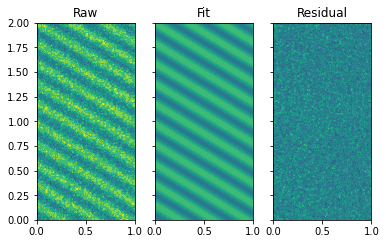

In [7]:
# Finally fit the fringes
popt, pcov = opt.curve_fit(fringes,
                           (x, y),
                           noisy_image,
                           p0=guess,
                           bounds=bounds
                           )
# Print the parameters
parameters = ("Amplitude", "Offset", "Spatial frequency", "Rotation", "Phase")
print("Fitted parameters")
print(40*"-")
for i, param in enumerate(parameters):
    print("{:<20} = {:.3f} +- {:.3f}".format(param, popt[i], pcov[i, i]**0.5))
print(40*"-")

# Reshape and plot the ravelled images
fitted_image = fringes((x, y), *popt)
fitted_image = fitted_image.reshape(shape)
noisy_image = noisy_image.reshape(shape)
residual = noisy_image - fitted_image

# Same vmin and vmax for all images
vmax = max(noisy_image.max(), fitted_image.max(), residual.max())
vmin = min(noisy_image.min(), fitted_image.min(), residual.min())
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)
for title, data, ax in zip(("Raw", "Fit", "Residual"),
                           (noisy_image, fitted_image, residual),
                           axes.flat):
    im = ax.contourf(x, y, data, vmin=vmin, vmax=vmax, origin="lower")
    ax.set_aspect("equal")
    ax.title.set_text(title)
plt.show()